In [4]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline

df = pd.read_csv('../deep learning/income.csv')

In [5]:
print(len(df))
df.head()

30000


,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,27,Male,HS-grad,9,Never-married,Private,Craft-repair,40,<=50K,0
1,47,Male,Masters,14,Married,Local-gov,Exec-managerial,50,>50K,1
2,59,Male,HS-grad,9,Divorced,Self-emp,Prof-specialty,20,<=50K,0
3,38,Female,Prof-school,15,Never-married,Federal-gov,Prof-specialty,57,>50K,1
4,64,Female,11th,7,Widowed,Private,Farming-fishing,40,<=50K,0


In [7]:
df.columns

Index(['age', 'sex', 'education', 'education-num', 'marital-status',
       'workclass', 'occupation', 'hours-per-week', 'income', 'label'],
      dtype='object')

In [9]:
df = shuffle(df, random_state=101)
df.reset_index(drop=True, inplace=True)
df.head()

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,23,Female,HS-grad,9,Never-married,Private,Other-service,50,<=50K,0
1,37,Female,Prof-school,15,Married,State-gov,Prof-specialty,39,>50K,1
2,34,Male,Some-college,10,Divorced,Private,Adm-clerical,40,<=50K,0
3,31,Male,HS-grad,9,Married,Private,Craft-repair,40,>50K,1
4,20,Female,Some-college,10,Never-married,Private,Sales,25,<=50K,0


In [10]:
cat_cols = ['sex','education','marital-status','workclass','occupation']
cont_cols = ['age','hours-per-week']
y_col = ['label']

print(f'cat_cols  has {len(cat_cols)} columns')
print(f'cont_cols has {len(cont_cols)} columns')
print(f'y_col     has {len(y_col)} column')


cat_cols  has 5 columns
cont_cols has 2 columns
y_col     has 1 column


In [11]:

for col in cat_cols:
    df[col] = df[col].astype('category')


In [12]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs


[(2, 1), (14, 7), (6, 3), (5, 3), (12, 6)]

In [13]:
cats = np.stack([df[col].cat.codes.values for col in cat_cols], axis=1)
cats[:5]


array([[ 0, 10,  3,  2,  6],
       [ 0, 12,  1,  4,  7],
       [ 1, 13,  0,  2,  0],
       [ 1, 10,  1,  2,  1],
       [ 0, 13,  3,  2,  9]], dtype=int8)

In [14]:
cats = torch.tensor(cats, dtype=torch.int64)

In [16]:
conts = np.stack([df[col].values for col in cont_cols], axis=1)
conts[:5]


array([[23, 50],
       [37, 39],
       [34, 40],
       [31, 40],
       [20, 25]])

In [17]:
conts = torch.tensor(conts, dtype=torch.float32)


In [18]:
y = torch.tensor(df[y_col].values, dtype=torch.int64).flatten()


In [19]:
b = 30000  
t = 5000  

cat_train = cats[:b-t]
cat_test  = cats[b-t:b]

con_train = conts[:b-t]
con_test  = conts[b-t:b]

y_train   = y[:b-t]
y_test    = y[b-t:b]


In [20]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in, i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1], out_sz))
        
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x


In [21]:
torch.manual_seed(33)

In [22]:
model = TabularModel(emb_szs, n_cont=len(cont_cols), out_sz=2, layers=[50], p=0.4)
model


TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(14, 7)
    (2): Embedding(6, 3)
    (3): Embedding(5, 3)
    (4): Embedding(12, 6)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=50, out_features=2, bias=True)
  )
)

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i += 1
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    if i % 25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}')
print(f'\nDuration: {time.time() - start_time:.0f} seconds')


epoch:   1  loss: 0.81344736
epoch:  26  loss: 0.59463936
epoch:  51  loss: 0.51533055
epoch:  76  loss: 0.46403277
epoch: 101  loss: 0.42922780
epoch: 126  loss: 0.40061691
epoch: 151  loss: 0.37124613
epoch: 176  loss: 0.35843733
epoch: 201  loss: 0.34799820
epoch: 226  loss: 0.33588532
epoch: 251  loss: 0.33127117
epoch: 276  loss: 0.32283258
epoch: 300  loss: 0.31734011

Duration: 41 seconds


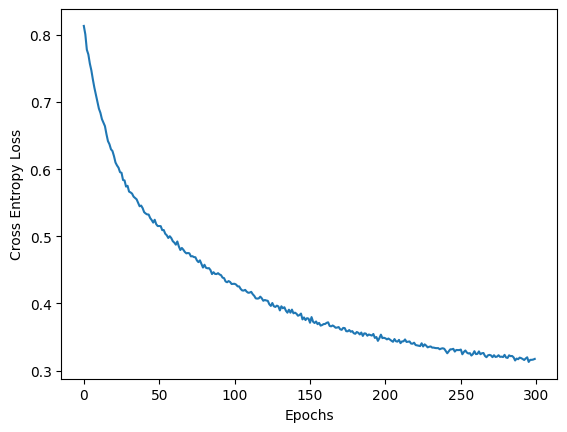

In [25]:
plt.plot([l.item() for l in losses])
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epochs")
plt.show()


In [26]:
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = criterion(y_val, y_test)

print(f'CE Loss: {loss:.8f}')


CE Loss: 0.33355415


In [27]:
correct = 0
for i in range(len(y_test)):
    if y_val[i].argmax().item() == y_test[i].item():
        correct += 1

print(f'{correct} out of {len(y_test)} = {correct/len(y_test)*100:.2f}% correct')


4232 out of 5000 = 84.64% correct


In [28]:
def predict_new(age, sex, education_num, marital_status, workclass, occupation, hours):
    # dictionaries (must match categorical ordering used earlier)
    sex_d = dict(Female=0, Male=1)
    edu_d = {cat:i for i,cat in enumerate(df['education'].cat.categories)}
    mar_d = {cat:i for i,cat in enumerate(df['marital-status'].cat.categories)}
    work_d = {cat:i for i,cat in enumerate(df['workclass'].cat.categories)}
    occ_d = {cat:i for i,cat in enumerate(df['occupation'].cat.categories)}
    
    # Build categorical tensor
    cats = torch.tensor([[sex_d[sex], edu_d[education_num], mar_d[marital_status], work_d[workclass], occ_d[occupation]]], dtype=torch.int64)
    conts = torch.tensor([[age, hours]], dtype=torch.float32)
    
    model.eval()
    with torch.no_grad():
        pred = model(cats, conts)
        return pred.argmax().item()

# RUN YOUR CODE HERE:
print(predict_new(22, 'Male', 'HS-grad', 'Never-married', 'Private', 'Sales', 40))


0
